<a href="https://colab.research.google.com/github/JarnovdKolk/Test/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision timm pandas pillow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Define paths (update these to match your Google Drive paths)
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/images_training_rev1GOED"  # Path to images
LABELS_CSV = "/content/drive/MyDrive/Colab Notebooks/training_solutions_rev1GOED.csv"

NUM_CLASSES = 37  # Number of output classes for Galaxy Zoo


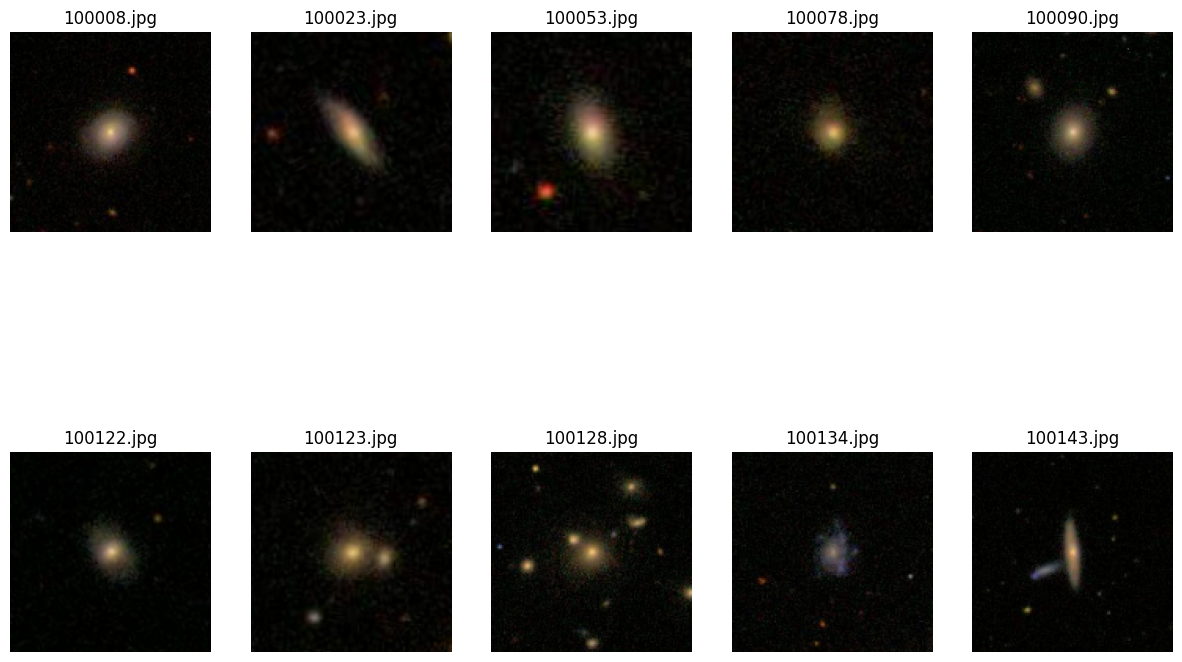

In [5]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load the first 10 images
image_files = sorted(os.listdir(DATA_DIR))[:10]  # Get the first 10 image filenames
images = []
for img_name in image_files:
    img_path = os.path.join(DATA_DIR, img_name)
    img = image.load_img(img_path, target_size=(128, 128))  # Resize for display
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    images.append(img_array)

# Display the images
plt.figure(figsize=(15, 10))
for i, img_array in enumerate(images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_array)
    plt.title(image_files[i])
    plt.axis('off')
plt.show()

In [ ]:
import pandas as pd

# Load the labels CSV
labels_df = pd.read_csv(LABELS_CSV)
# Extract rows 2–11 (index 1–10 in zero-based indexing)
first_10_labels = labels_df.iloc[1:11]
print(first_10_labels)





    GalaxyID  Class1.1  Class1.2  Class1.3  Class2.1  Class2.2  Class3.1  \
1     100023  0.327001  0.663777  0.009222  0.031178  0.632599  0.467370   
2     100053  0.765717  0.177352  0.056931  0.000000  0.177352  0.000000   
3     100078  0.693377  0.238564  0.068059  0.000000  0.238564  0.109493   
4     100090  0.933839  0.000000  0.066161  0.000000  0.000000  0.000000   
5     100122  0.738832  0.238159  0.023009  0.000000  0.238159  0.000000   
6     100123  0.462492  0.456033  0.081475  0.000000  0.456033  0.000000   
7     100128  0.687783  0.288344  0.023873  0.000000  0.288344  0.069098   
8     100134  0.021834  0.976952  0.001214  0.021751  0.955201  0.313077   
9     100143  0.269843  0.730157  0.000000  0.730157  0.000000  0.000000   
10    100150  0.429378  0.524901  0.045721  0.000000  0.524901  0.000000   

    Class3.2  Class4.1  Class4.2  ...  Class9.3  Class10.1  Class10.2  \
1   0.165229  0.591328  0.041271  ...  0.018764   0.000000   0.131378   
2   0.177352  0.0

POGINGEN!!!!

Images shape: (10, 128, 128, 3)
Labels shape: (10, 37)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 37)                  │       1,818,661 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,818,661 (6.94 MB)

 Trainable params: 1,818,661 (6.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.0333 - loss: 15.3877    
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3639 - loss: 22.1438
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3264 - loss: 26.3218
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7014 - loss: 18.7068
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6611 - loss: 22.9168
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0333 - loss: 32.4909
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3764 - loss: 27.2829
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5000 - loss: 34.9440
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3972 - loss: 29.9768
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3556 - loss: 35.1890
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5000 - loss: 33.9996
Loss: 33.999603271484375, Accuracy: 0.5


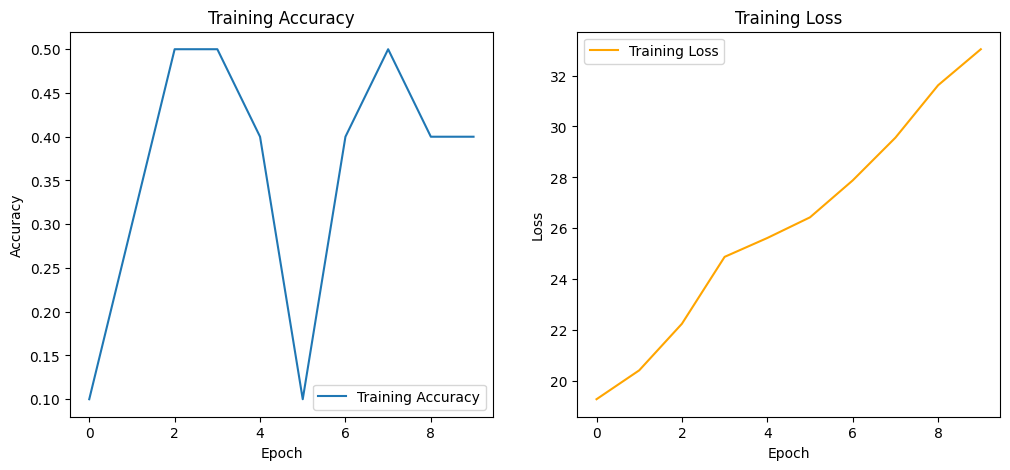

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Define paths
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/images_training_rev1GOED"  # Path to images
LABELS_CSV = "/content/drive/MyDrive/Colab Notebooks/training_solutions_rev1GOED.csv"

# Load the first 10 images
image_files = sorted(os.listdir(DATA_DIR))[:10]  # Get the first 10 image filenames
images = []
for img_name in image_files:
    img_path = os.path.join(DATA_DIR, img_name)
    img = image.load_img(img_path, target_size=(128, 128))  # Resize for display
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    images.append(img_array)

# Convert images to a numpy array
images = np.array(images)

# Load the labels CSV
labels_df = pd.read_csv(LABELS_CSV)
# Extract rows 2–11 (index 1–10 in zero-based indexing)
first_10_labels = labels_df.iloc[1:11]

# Drop the 'GalaxyID' column (not needed for training)
labels = first_10_labels.drop(columns=['GalaxyID']).values

# Verify shapes
print("Images shape:", images.shape)  # Should be (10, 128, 128, 3)
print("Labels shape:", labels.shape)  # Should be (10, 37)

# Build a simple model
model = Sequential([
    Flatten(input_shape=(128, 128, 3)),  # Flatten the 128x128x3 image
    Dense(37, activation='softmax')  # Output layer with 37 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(images, labels, epochs=5, batch_size=2)

# Evaluate the model
loss, accuracy = model.evaluate(images, labels)
print(f"Loss: {loss}, Accuracy: {accuracy}")

import matplotlib.pyplot as plt

# Plot training accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


### **Tot nu toe werkt alles hieronder het best!!!**

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define paths
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/images_training_rev1GOED"  # Path to images
LABELS_CSV = "/content/drive/MyDrive/Colab Notebooks/training_solutions_rev1GOED.csv"

# Number of images to use
NUM_IMAGES = 1000

# Load all image filenames
image_filenames = sorted(os.listdir(DATA_DIR))[:NUM_IMAGES]  # Get first NUM_IMAGES image filenames
image_ids = [int(img_name.split('.')[0]) for img_name in image_filenames]  # Extract GalaxyIDs from filenames

# Load the labels CSV
labels_df = pd.read_csv(LABELS_CSV)

# Filter labels to only include those corresponding to the images
labels_df = labels_df[labels_df['GalaxyID'].isin(image_ids)]

# Sort labels by GalaxyID to match the order of images
labels_df = labels_df.set_index('GalaxyID').loc[image_ids].reset_index()

# Load and preprocess images
images = []
for img_name in image_filenames:
    img_path = os.path.join(DATA_DIR, img_name)
    try:
        img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224
        img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    except Exception as e:
        print(f"Skipping {img_name} due to error: {e}")

# Convert images to a numpy array
images = np.array(images)

# Extract labels (drop the 'GalaxyID' column)
labels = labels_df.drop(columns=['GalaxyID']).values

# Verify shapes
print("Images shape:", images.shape)  # Should be (NUM_IMAGES, 224, 224, 3)
print("Labels shape:", labels.shape)  # Should be (NUM_IMAGES, 37)


Images shape: (1000, 224, 224, 3)
Labels shape: (1000, 37)


1000


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.0336 - loss: 19.6926 - val_accuracy: 0.6280 - val_loss: 16.9907 - learning_rate: 0.0010
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 350ms/step - accuracy: 0.2428 - loss: 18.0907 - val_accuracy: 0.6280 - val_loss: 15.8039 - learning_rate: 0.0010
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 352ms/step - accuracy: 0.5227 - loss: 17.2728 - val_accuracy: 0.6280 - val_loss: 18.8877 - learning_rate: 0.0010
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.5633 - loss: 20.2147 - val_accuracy: 0.6280 - val_loss: 23.9006 - learning_rate: 0.0010
Epoch 5/10
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.5677 - loss: 26.3952
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 349ms/step - accuracy: 0.5674 - loss: 26.4999 - val_accuracy: 0.6280 - val_loss: 31.7192 - learning_rate: 0.0010
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - accuracy: 0.5801 - loss: 33.2803

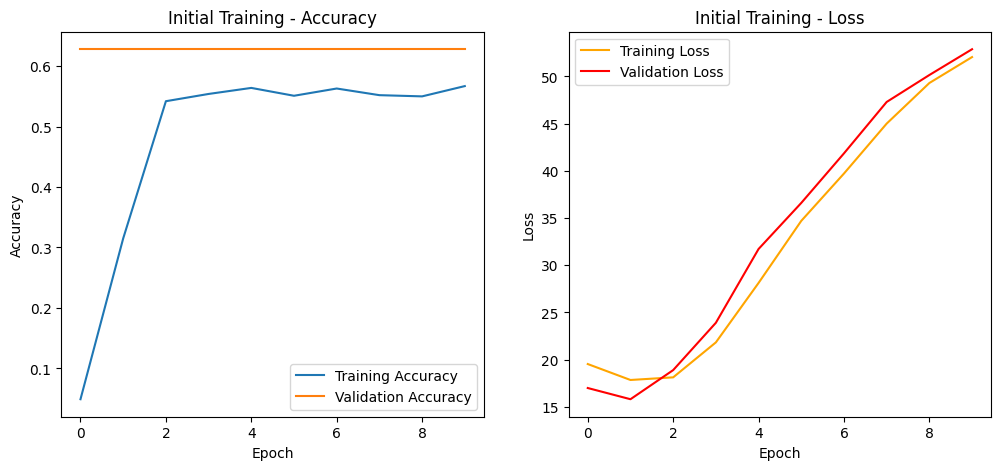

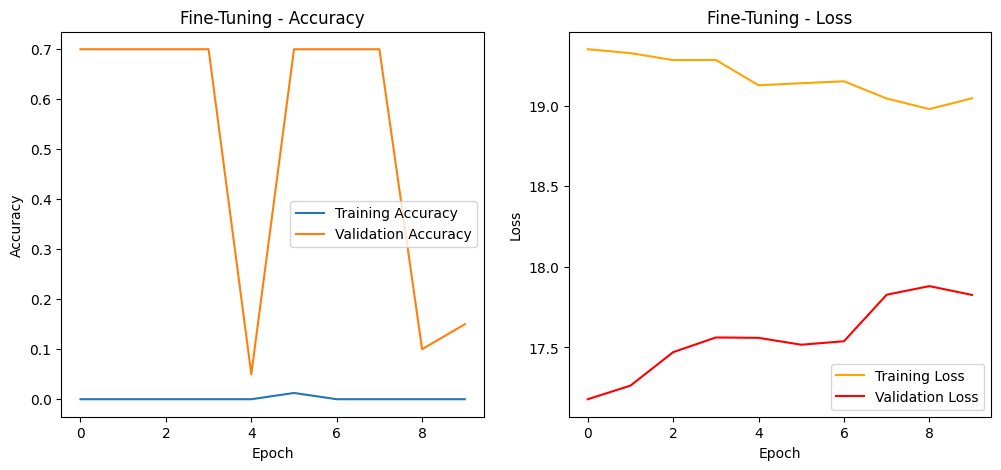

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# Data Augmentation
augmentor = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Load EfficientNetV2 without top layers
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=( 224, 224, 3))
base_model.trainable = False  # Freeze base model initially

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Stabilizes training
x = Dropout(0.3)(x)  # Increased dropout
x = Dense(37, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile model with lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train initial model
history = model.fit(augmentor.flow(images, labels, batch_size=32),
                    epochs=10, validation_data=(images, labels),
                    callbacks=[lr_scheduler])

# Fine-Tuning: Unfreeze some base model layers
base_model.trainable = True
for layer in base_model.layers[:100]:  # Keep first 100 layers frozen
    layer.trainable = False

# Compile with even lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train fine-tuned model
fine_tune_history = model.fit(augmentor.flow(images, labels, batch_size=32),
                              epochs=10, validation_data=(images, labels),
                              callbacks=[lr_scheduler])


# Evaluate model
loss, accuracy = model.evaluate(images, labels)
print(f"Final Loss: {loss}, Final Accuracy: {accuracy}")

# Plot training history
def plot_training(history, title="Training Performance"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='orange')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training(history, "Initial Training")
plot_training(history_fine, "Fine-Tuning")


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# Data Augmentation
augmentor = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Load EfficientNetV2 without top layers (keep all base layers frozen)
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom classification head (only train this part)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Stabilizes training
x = Dropout(0.3)(x)  # Dropout for regularization
x = Dense(37, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile model with higher learning rate for final layer
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train only the final layer
history = model.fit(augmentor.flow(images, labels, batch_size=32),
                    epochs=10, validation_data=(images, labels),
                    callbacks=[lr_scheduler])

# Evaluate model
loss, accuracy = model.evaluate(images, labels)
print(f"Final Loss: {loss}, Final Accuracy: {accuracy}")

# Plot training history
def plot_training(history, title="Training Performance"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='orange')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training(history, "Training Performance")


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


NameError: name 'images' is not defined